In [2962]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage as ndi
from scipy.stats import mode
from sklearn.cluster import DBSCAN

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

In [2963]:
def angular_difference(theta1, theta2):
    # Normalize angles between 0 and pi
    theta1 = np.mod(theta1, np.pi)
    theta2 = np.mod(theta2, np.pi)
    # Compute the absolute difference in angles
    diff = np.abs(theta1 - theta2)
    # Angles are periodic, with period pi (180 degrees), so take the min with pi - diff
    print(diff)
    print(np.pi)
    return min(diff, (np.pi - diff))

In [2964]:
def hough_line_intersection(line1, line2):
    # Find the intersection of two lines defined by Hough transform.
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)

    return float(x0), float(y0)  # Make sure the return values are floats

In [2965]:
def find_intersections(hough_lines, convex_hull, angular_threshold):
    angular_threshold = np.radians(angular_threshold)
    intersections = []
    # Find all the intersection points from the lines
    for i, line1 in enumerate(hough_lines):
        for line2 in hough_lines[i+1:]:
            rho1, theta1 = line1[0]
            rho1, theta2 = line2[0]
            if angular_difference(theta1, theta2) > angular_threshold:
                try:
                    x, y = hough_line_intersection(line1, line2)
                    intersections.append((x, y))
                except np.linalg.LinAlgError:  # This occurs when there's no intersection (parallel lines).
                    continue

    # Convert hull points to a suitable format for pointPolygonTest
    hull_points = convex_hull.reshape(-1, 2)

    # Filter intersections that are close to the convex hull
    near_hull_intersections = []
    for point in intersections:
        # Convert point to a tuple of floats if it isn't already
        dist = cv2.pointPolygonTest(hull_points, (point[0],point[1]), True)
        thresh = cv2.arcLength(convex_hull,True)/200

        if dist > -thresh and dist < thresh:  # Adjust the threshold as needed
            near_hull_intersections.append((int(point[0]), int(point[1])))

    return near_hull_intersections

In [2966]:
def is_circle(contour, epsilon_factor=0.02, roundness_threshold=0.71):
    approx = cv2.approxPolyDP(contour, epsilon_factor * cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0: return False
    area_of_circle = (perimeter ** 2) / (4 * 3.14159)
    roundness = area / area_of_circle
    return roundness > roundness_threshold

In [2967]:
def pad_to_square(image):
    # Calculate the difference between the height and the width
    height, width = image.shape[:2]
    delta = abs(height - width)
    top = bottom = left = right = 0

    # Pad width if the image is taller than it is wide
    if height > width:
        left = right = delta // 2
    # Pad height if the image is wider than it is tall
    elif width > height:
        top = bottom = delta // 2

    # Use the last pixel value for padding
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    
    # If the delta is odd, we need to add one more pixel of padding to one side
    if delta % 2 != 0:
        if width < height:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 0, 0, 1, cv2.BORDER_REPLICATE)
        else:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 1, 0, 0, cv2.BORDER_REPLICATE)

    return padded_image

In [2968]:
def line_intersection(p1, p2, p3, p4):
    # Unpack points
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    
    # Calculate determinants
    det1 = x1 * y2 - y1 * x2
    det2 = x3 * y4 - y3 * x4
    xnum = det1 * (x3 - x4) - (x1 - x2) * det2
    ynum = det1 * (y3 - y4) - (y1 - y2) * det2
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    # Intersection point
    x = xnum / denom
    y = ynum / denom
    return x, y

In [2969]:
# crop image to have a square image
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

In [2970]:
def most_common_hue(hsv_image, center, radius):
    sat_threshold=50
    val_threshold=140

    # Create a mask for the round area
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, radius, (255), thickness=-1)
    
    # Extract hue values within the mask
    hues = hsv_image[:,:,0][mask == 255]
    s = hsv_image[:,:,1][mask == 255]
    v = hsv_image[:,:,2][mask == 255]

    # Find the most common hue
    if(mode(s)[0] <= sat_threshold and mode(v)[0] >= val_threshold):
        return -1
    else: 
        return mode(hues)[0]

In [2971]:
def hue_to_color_name_and_bgr(hue):
    # Define hue ranges for common colors
    color_ranges = {
        "red": range(0, 8),  # Red has to be split due to its position on the hue wheel
        "orange": range(8, 20), 
        "yellow": range(20, 35), 
        "green": range(35, 85),
        "blue": range(85, 125),
        # "white": Not defined by hue
        "red2": range(160, 180)  # The second part of red
    }

    # Determine color name
    color_name = None
    for color, hue_range in color_ranges.items():
        if hue == -1:
            return "white",(255,255,255)
        elif hue in hue_range:
            color_name = color
            break

    # Handle the two ranges for red
    if color_name == "red2":
        color_name = "red"

    if color_name is None:
        return None, None

    # Convert hue to BGR
    hsv_color = np.uint8([[[hue, 255, 255]]])  # Hue, Saturation, Value
    bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]

    return color_name,tuple(bgr_color)

In [2972]:
# crop image to have a square image
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

In [2973]:
def pad_to_square(image):
    # Calculate the difference between the height and the width
    height, width = image.shape[:2]
    delta = abs(height - width)
    top = bottom = left = right = 0

    # Pad width if the image is taller than it is wide
    if height > width:
        left = right = delta // 2
    # Pad height if the image is wider than it is tall
    elif width > height:
        top = bottom = delta // 2

    # Use the last pixel value for padding
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    
    # If the delta is odd, we need to add one more pixel of padding to one side
    if delta % 2 != 0:
        if width < height:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 0, 0, 1, cv2.BORDER_REPLICATE)
        else:
            padded_image = cv2.copyMakeBorder(padded_image, 0, 1, 0, 0, cv2.BORDER_REPLICATE)

    return padded_image

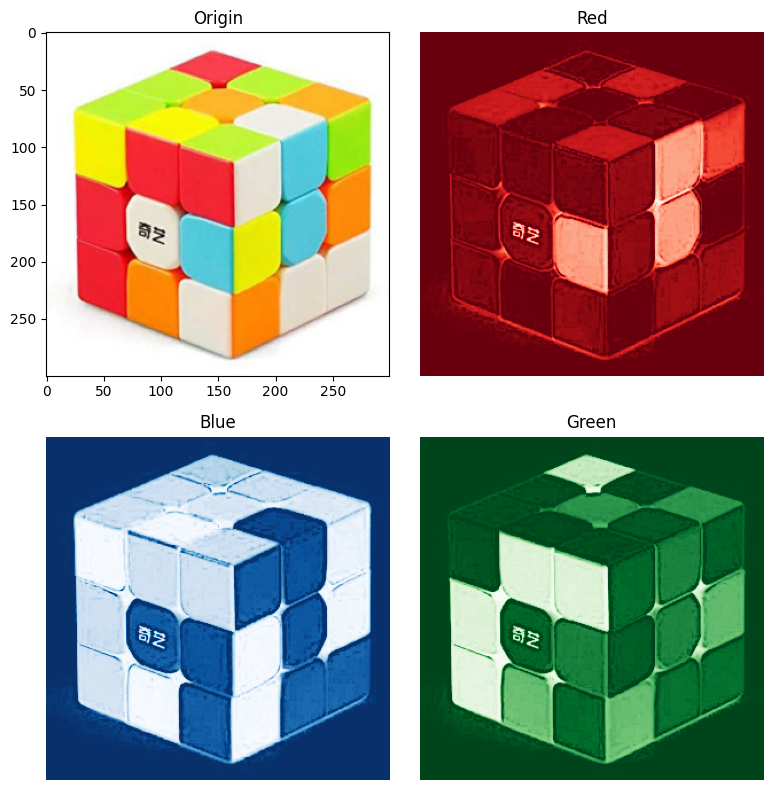

In [2974]:
original_input_image = pad_to_square(cv2.imread('Classification2/border1.jpeg'))
input_image = crop_square(original_input_image,300)

blue, green, red = cv2.split(input_image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 4.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 4.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 4.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)

plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Origin')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

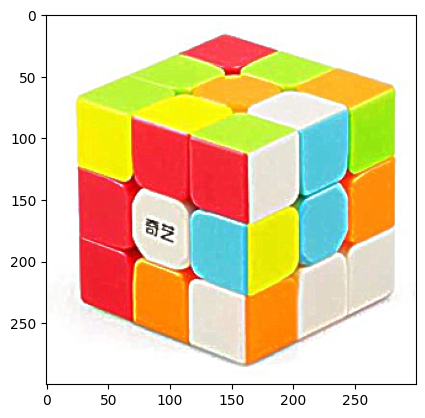

In [2975]:
# Unione dei colori
from skimage.morphology import diamond
from skimage import filters

high_pass_input_image = cv2.merge((blue, green, red))
HP_gray_image = cv2.cvtColor(high_pass_input_image, cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
plt.imshow(cv2.cvtColor(high_pass_input_image, cv2.COLOR_BGR2RGB))

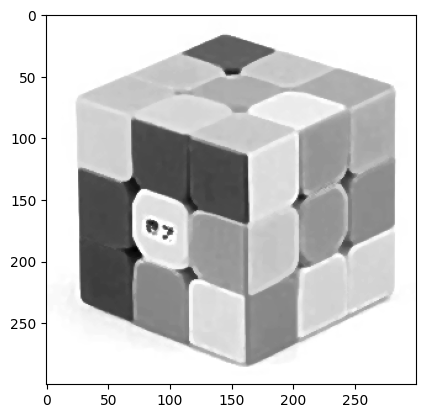

In [2976]:
med = filters.median(HP_gray_image,diamond(3))
plt.imshow(med,cmap="gray")

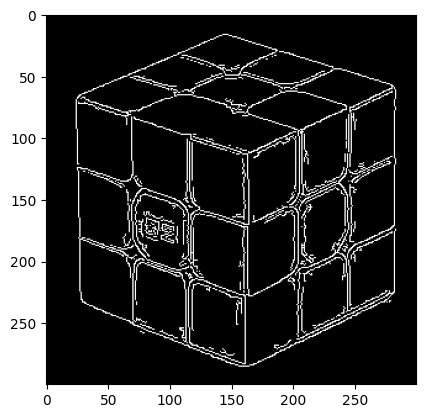

In [2977]:
# try to identify the edges inside the image

iedges = cv2.Canny(HP_gray_image,30,150)

plt.imshow(iedges,cmap="gray")

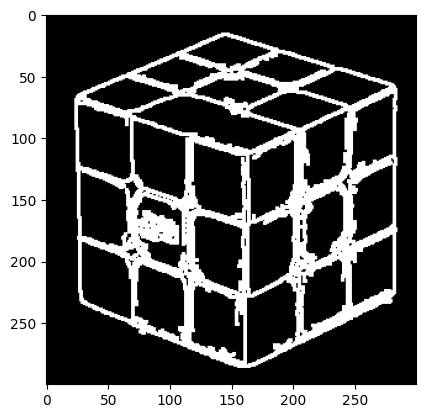

In [2978]:
# espandiamo il colore bianco, per cercare di riempire i buchi, sopratutto sul bordo

kernel = np.ones((3,3),np.uint8)
dilatation = cv2.dilate(iedges,kernel,iterations = 1)
plt.imshow(dilatation,cmap="gray")

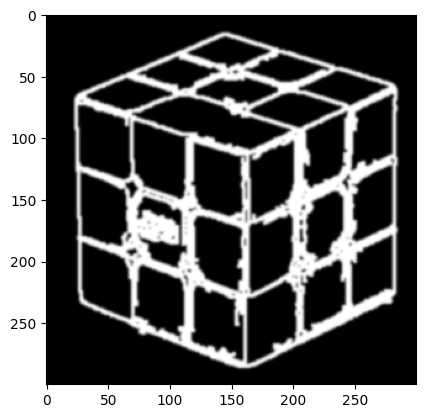

In [2979]:
smooth = filters.gaussian(dilatation, sigma=1)
plt.imshow(smooth,cmap="gray")

In [2980]:
# increase the contrast to make pop-up more the borders of the cube

smooth = cv2.normalize(smooth, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

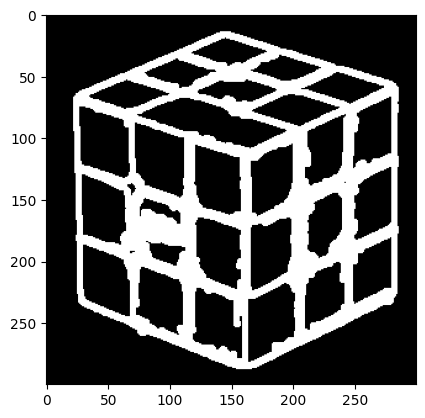

In [2981]:
# effettuiamo threshold, portando a 255 tutto ciò che non è pressochè (ora i bordi dovrebbero essere unificati)
ret,thresh = cv2.threshold(smooth,30,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap="gray")

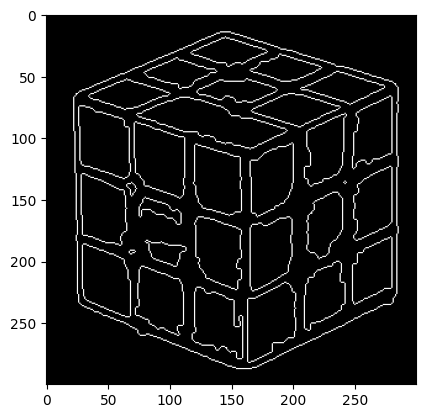

In [2982]:
# identification of the cube and other obkects from the nosie

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
borders = np.zeros_like(thresh)
edge_image = cv2.drawContours(borders, contours, -1, (255, 255, 255), 1)
plt.imshow(edge_image,cmap="gray")

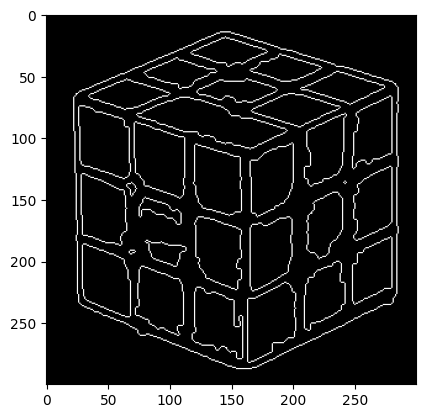

In [2983]:
# diamo per scontato che ci può essere del rumore nel background
# per fare in modo di rimoverlo, creiamo uno cornice nera intorno alla immagine (se non c'è noise allora non è visibile)

thickness = 2

cv2.line(edge_image, (0,0), (0,300), 0, thickness)
cv2.line(edge_image, (0,300), (300,300), 0, thickness)
cv2.line(edge_image, (300,300), (300,0), 0, thickness)
cv2.line(edge_image, (300,0), (0,0), 0, thickness)

plt.imshow(edge_image,cmap="gray")

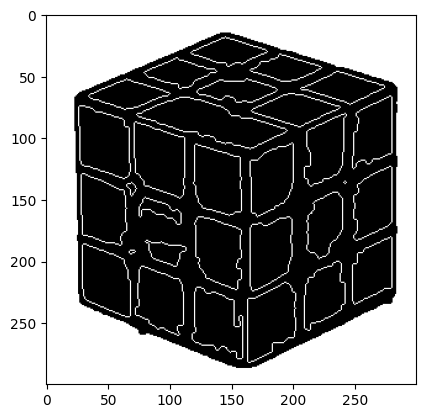

In [2984]:
# facciamo un fill per rimuovere noise nel background, partendo dalla cornice nera creata precedentemente
# proprio grazia alla cornice, partendo da un solo punto, possiamo rimepire da tutto il bordo!

cv2.floodFill(edge_image, None, (0, 0), (255,255,255))

plt.imshow(edge_image,cmap="gray")

In [2985]:
# aumento della dimensione della immagine
increased_dilatated = cv2.copyMakeBorder(edge_image,100,100,100,100,cv2.BORDER_CONSTANT,value=255)

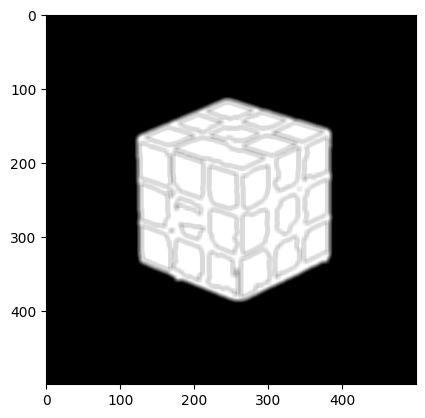

In [2986]:
# effettuato mean kernel per cercare di smussare eventuale noise, e rimpire anche i buchi

mean_kernel = np.full((7, 7), 1/49)
mean = ndi.correlate(255 - increased_dilatated, mean_kernel)
plt.imshow(mean,cmap="gray")

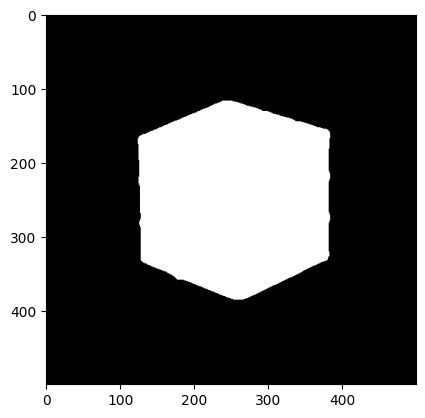

In [2987]:
# effettuiamo threshold, portando a 255 tutto ciò che è pressochè nero (si si vede che grazie allo smussamento molti buchi vengono riempiti)
ret,thresh = cv2.threshold(mean,150,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap="gray")

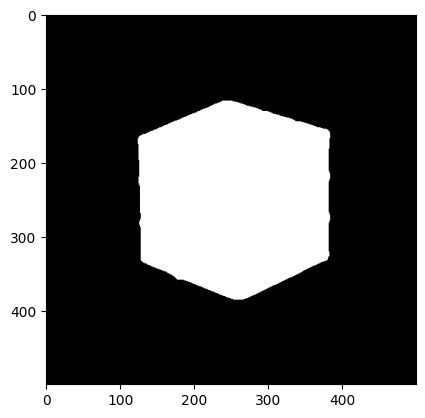

In [2988]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_contour=contours[0]
max_area=cv2.contourArea(max_contour)

for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    if(max_area<area):
        max_contour=c
        max_area=area

# Determine which area is larger and create a mask
single_thresh = np.zeros_like(thresh)
cv2.drawContours(single_thresh, [max_contour], -1, (255,255,255), -1)
perimeter = cv2.arcLength(max_contour, True)

# Apply the mask
plt.imshow(single_thresh,cmap="gray")

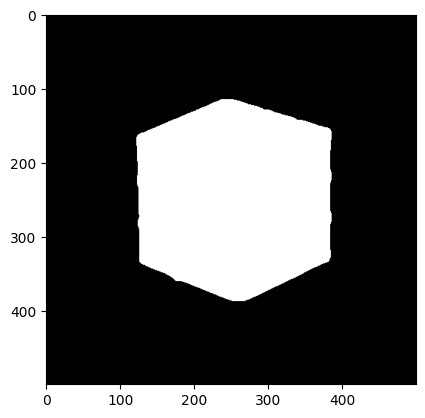

In [2989]:
# espandiamo il colore bianco, per cercare di riempire i buchi, non solo all'interno ma anche sul bordo

kernel = np.ones((3,3),np.uint8)
dilatation = cv2.dilate(single_thresh,kernel,iterations = 2)
plt.imshow(dilatation,cmap="gray")

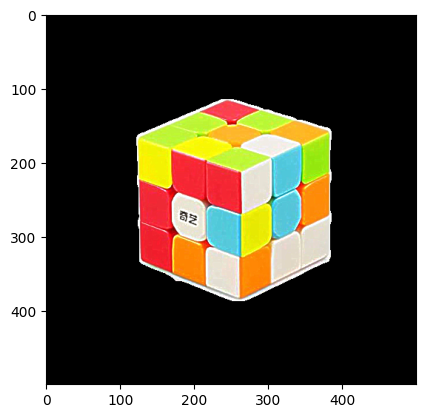

In [2990]:
# appliyng the ROI to the input image
bigger_high_pass_input_image = cv2.copyMakeBorder(high_pass_input_image,100,100,100,100,cv2.BORDER_CONSTANT,value=0)

ROI = cv2.bitwise_and(bigger_high_pass_input_image, bigger_high_pass_input_image, mask=dilatation)
plt.imshow(cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB))

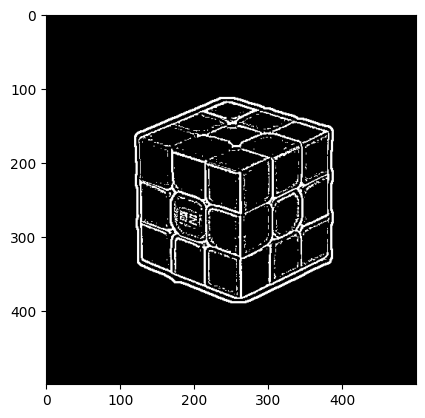

In [2991]:
ROI_thresholded = cv2.bitwise_not(cv2.adaptiveThreshold(cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 7))
plt.imshow(cv2.cvtColor(ROI_thresholded, cv2.COLOR_BGR2RGB))

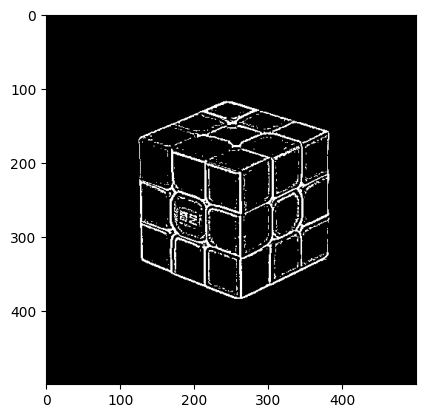

In [2992]:
contours, _ = cv2.findContours(ROI_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours by area and find the largest one, which in this case will be the ROI border
#c = max(contours, key = cv2.contourArea)
outer_hexagon_contour = contours[0][:, 0, :]

cv2.floodFill(ROI_thresholded, None, (outer_hexagon_contour[0][0],outer_hexagon_contour[0][1]), 0)
plt.imshow(ROI_thresholded,cmap="gray")

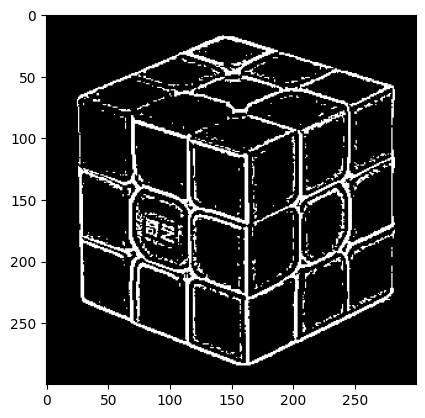

In [2993]:
# Calculate the center of the original image
center_x, center_y = 500 // 2, 500 // 2
# Calculate half of the new dimensions
half_new_size = 300 // 2, 300 // 2

# Calculate the top-left corner of the new crop area
start_x = center_x - half_new_size[0]
start_y = center_y - half_new_size[1]
# Calculate the bottom-right corner of the new crop area
end_x = center_x + half_new_size[0]
end_y = center_y + half_new_size[1]

# Crop the image
ROI_thresholded = ROI_thresholded[start_y:end_y, start_x:end_x]
plt.imshow(ROI_thresholded,cmap="gray")

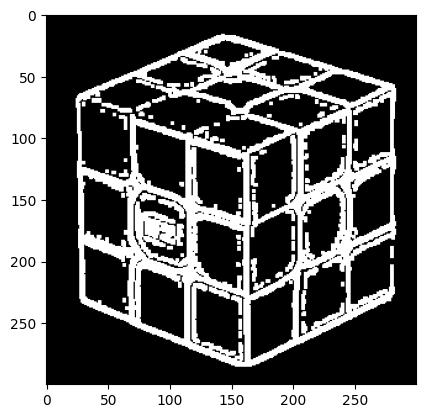

In [2994]:
ROI_thresholded = cv2.dilate(ROI_thresholded,np.ones((3,3),np.uint8),iterations = 1)
plt.imshow(ROI_thresholded,cmap="gray")

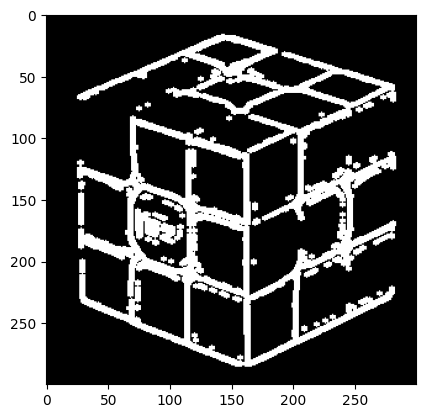

In [2995]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
ROI_thresholded = cv2.morphologyEx(ROI_thresholded, cv2.MORPH_OPEN, kernel)
plt.imshow(ROI_thresholded,cmap="gray")

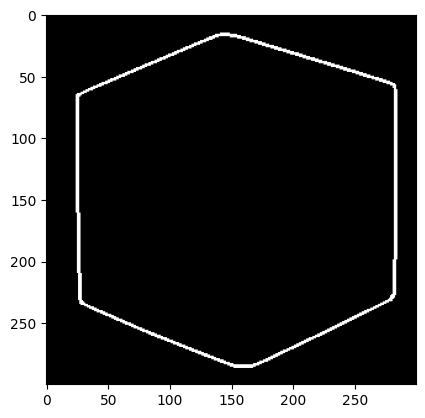

In [2996]:
# get the convex hull, to ignore all the gaps present on the border of the image
contours, _ = cv2.findContours(ROI_thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cont = np.vstack([contours[i] for i in range(len(contours))])

hull = cv2.convexHull(cont)
perimeter = cv2.arcLength(hull,True)
void = np.zeros_like(ROI_thresholded)
edge_image = cv2.drawContours(void, [hull], -1, 255, 2)
plt.imshow(void,cmap="gray")

In [2997]:
lines = cv2.HoughLines(void, 1, np.pi / 360, int(perimeter/15), None, 0, 0)

In [2998]:
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(void, pt1, pt2, 255, 1, cv2.LINE_AA)
plt.imshow(void,cmap="gray")

3.1328659057617188
3.141592653589793
0.008726646192371845
3.141592653589793
0.01745329238474369
3.141592653589793
3.115412712097168
3.141592653589793
3.1328659057617188
3.141592653589793
3.1241393089294434
3.141592653589793
0.0
3.141592653589793
0.008726646192371845
3.141592653589793
1.8675023317337036
3.141592653589793
1.876228928565979
3.141592653589793
1.8587756156921387
3.141592653589793
1.9547687768936157
3.141592653589793
1.8500490188598633
3.141592653589793
1.9634953737258911
3.141592653589793
3.1066861152648926
3.141592653589793
1.1082841157913208
3.141592653589793
1.972222089767456
3.141592653589793
1.1693705320358276
3.141592653589793
1.1780972480773926
3.141592653589793
1.9460420608520508
3.141592653589793
1.1257373094558716
3.141592653589793
1.1344640254974365
3.141592653589793
1.8849555253982544
3.141592653589793
1.8413223028182983
3.141592653589793
0.01745329238474369
3.141592653589793
1.186823844909668
3.141592653589793
0.03490658476948738
3.141592653589793
1.93731546401

C:\Users\Ceron\AppData\Local\Temp\ipykernel_37656\4203726660.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(x0), float(y0)  # Make sure the return values are floats


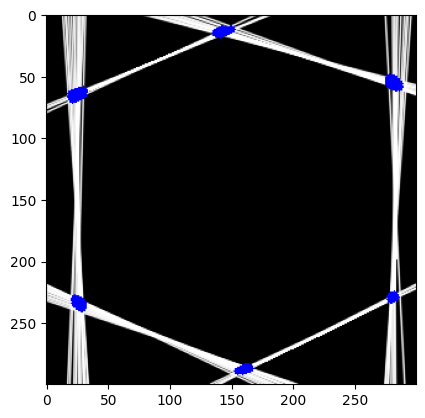

In [ ]:
angular_threshold = 20
#  get the intersection that only happen near the border of the cube
intersections = find_intersections(lines, hull, angular_threshold)
void2 = cv2.cvtColor(void,cv2.COLOR_GRAY2BGR)
for i in intersections:
    cv2.circle(void2,i,3,(255,0,0),-1)

plt.imshow(cv2.cvtColor(void2, cv2.COLOR_BGR2RGB))

In [ ]:
epsilon = 40  # Define the radius parameter epsilon which is the maximum distance between two samples for one to be considered as in the neighborhood of the other.
min_samples = 10  # Define the minimum number of points required to form a cluster
intersections = np.array(intersections)

db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(intersections)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = [intersections[labels == i] for i in range(n_clusters)]

# Calculate mean for each cluster
corners = [np.mean(cluster, axis=0) for cluster in clusters]

for i in range(len(corners)):
    corners[i] = corners[i].astype(int)

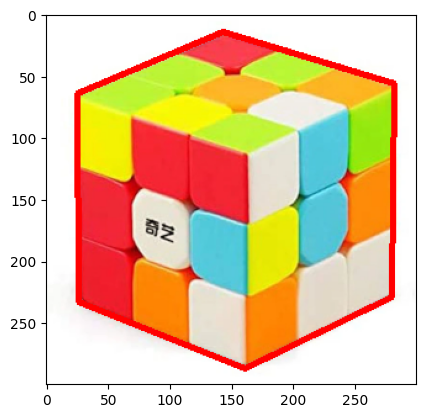

In [ ]:
sorted_vertices = sorted(corners, key=lambda point: (point[1]))
highest_vertex = tuple(sorted_vertices[0])
lowest_vertex = tuple(sorted_vertices[-1])

impression = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)

upper_right=lower_right=upper_left=lower_left=0
upper_right_angle=upper_left_angle=0
if(sorted_vertices[1][0] > sorted_vertices[2][0]):
    upper_right = tuple(sorted_vertices[1])
    upper_left = tuple(sorted_vertices[2])
else:
    upper_right = tuple(sorted_vertices[2])
    upper_left = tuple(sorted_vertices[1])
if(sorted_vertices[3][0] > sorted_vertices[4][0]):
    lower_right = tuple(sorted_vertices[3])
    lower_left = tuple(sorted_vertices[4])
else:
    lower_right = tuple(sorted_vertices[4])
    lower_left = tuple(sorted_vertices[3])

cv2.line(impression, upper_right, lower_right, (0, 0, 255), thickness = 3)
cv2.line(impression, upper_left, lower_left, (0, 0, 255), thickness = 3)
cv2.line(impression, lower_left, lowest_vertex, (0, 0, 255), thickness = 3)
cv2.line(impression, lower_right, lowest_vertex, (0, 0, 255), thickness = 3)
cv2.line(impression, upper_right, highest_vertex, (0, 0, 255), thickness = 3)
cv2.line(impression, upper_left, highest_vertex, (0, 0, 255), thickness = 3)

plt.imshow(cv2.cvtColor(impression, cv2.COLOR_BGR2RGB))

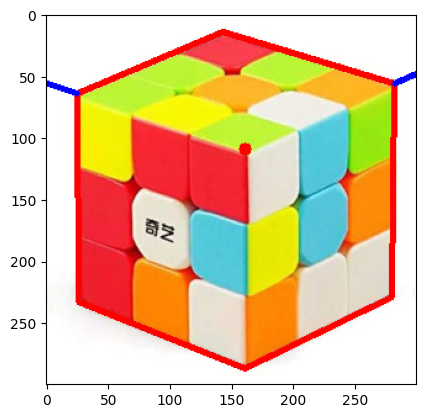

In [ ]:
intersection1 = line_intersection(lower_left,lowest_vertex,highest_vertex,upper_right)
intersection2 = line_intersection(lower_right,lowest_vertex,highest_vertex,upper_left)
center = line_intersection(intersection1,upper_left,intersection2,upper_right)
center = (int(center[0]),int(center[1]))

cv2.line(impression, (int(intersection1[0]),int(intersection1[1])), upper_left, (255, 0, 0), thickness = 3)
cv2.line(impression, (int(intersection2[0]),int(intersection2[1])), upper_right, (255, 0, 0), thickness = 3)
cv2.circle(impression, center, 5, (0,0,255), thickness=cv2.FILLED)
plt.imshow(cv2.cvtColor(impression, cv2.COLOR_BGR2RGB))

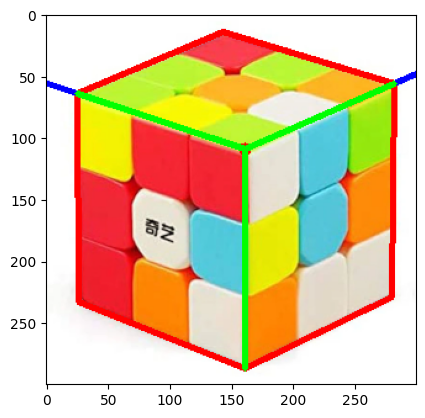

In [ ]:
cv2.line(impression, lowest_vertex, center, (0, 255, 0), thickness = 3)
cv2.line(impression, upper_left, center, (0, 255, 0), thickness = 3)
cv2.line(impression, upper_right, center, (0, 255, 0), thickness = 3)

plt.imshow(cv2.cvtColor(impression, cv2.COLOR_BGR2RGB))

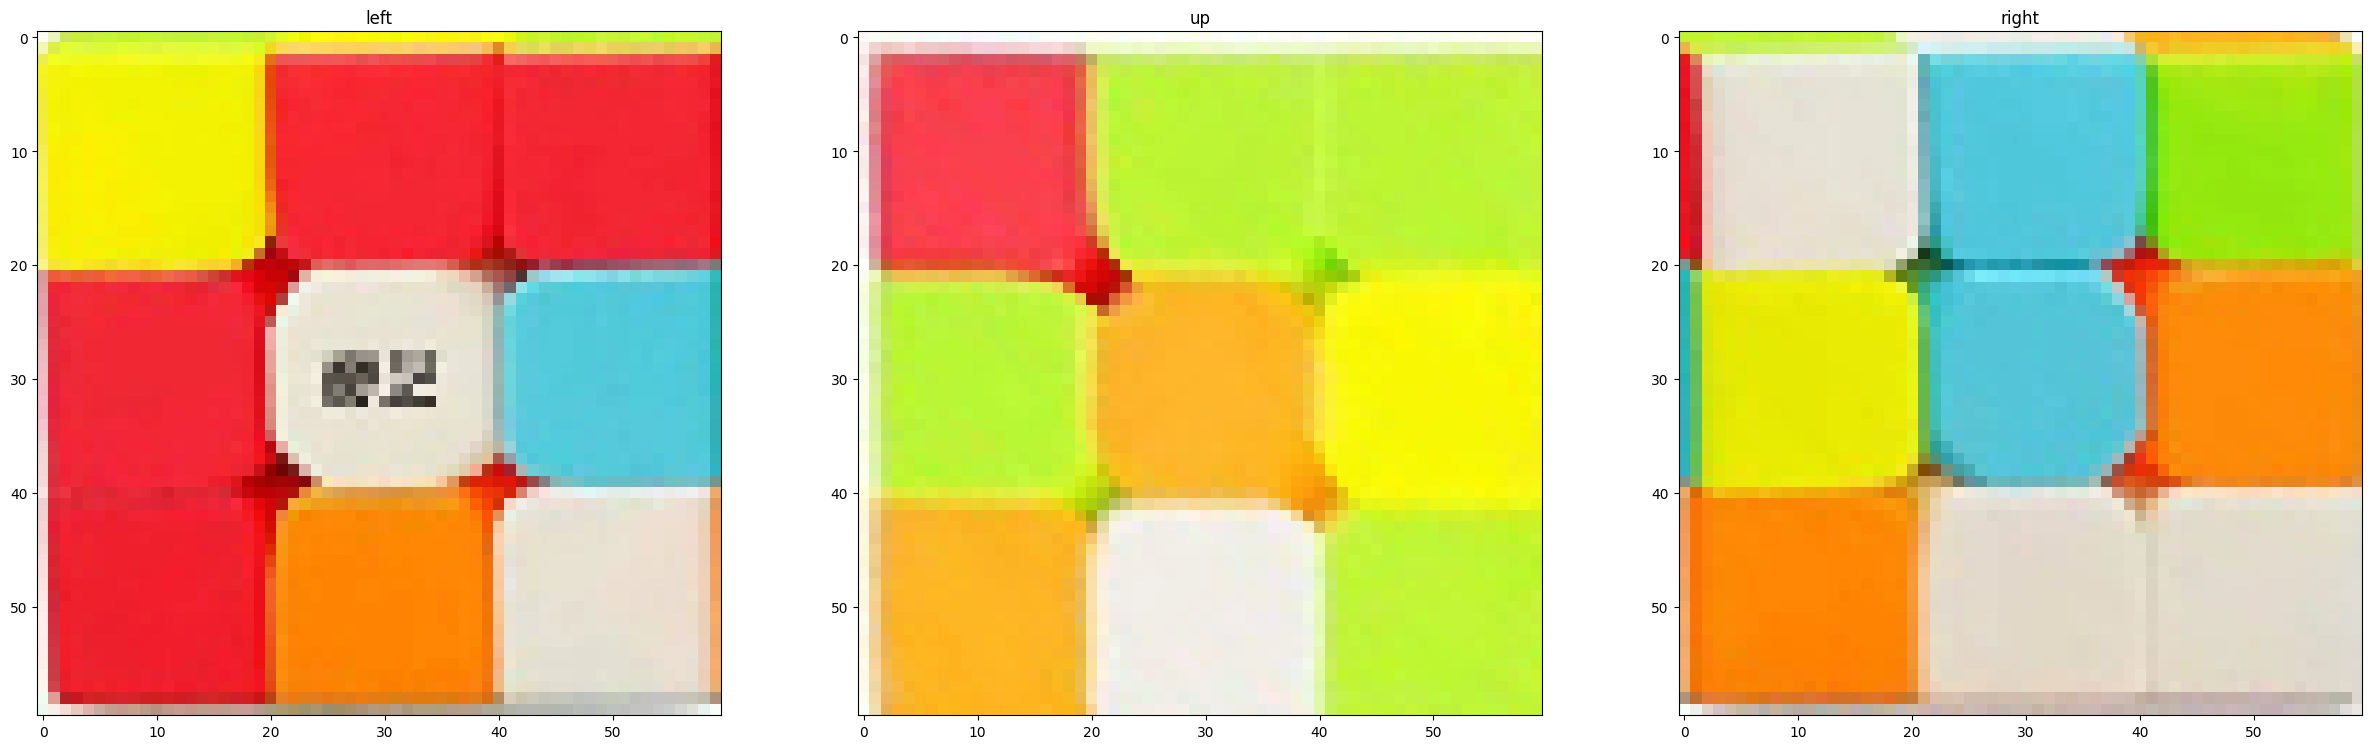

In [ ]:
dst_square_size = 60
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
dst_coordinates = np.array([[0, 0], [dst_square_size - 1, 0], [dst_square_size - 1, dst_square_size - 1], [0, dst_square_size - 1]], dtype=np.float32)

coordinates = np.array([highest_vertex, upper_left, center, upper_right], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image1 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

coordinates = np.array([ center, upper_right, lower_right, lowest_vertex], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image2 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

coordinates = np.array([ upper_left, center, lowest_vertex, lower_left], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image3 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

imshow_all(cv2.cvtColor(result_image3, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image2, cv2.COLOR_BGR2RGB),titles=["left","up","right"])

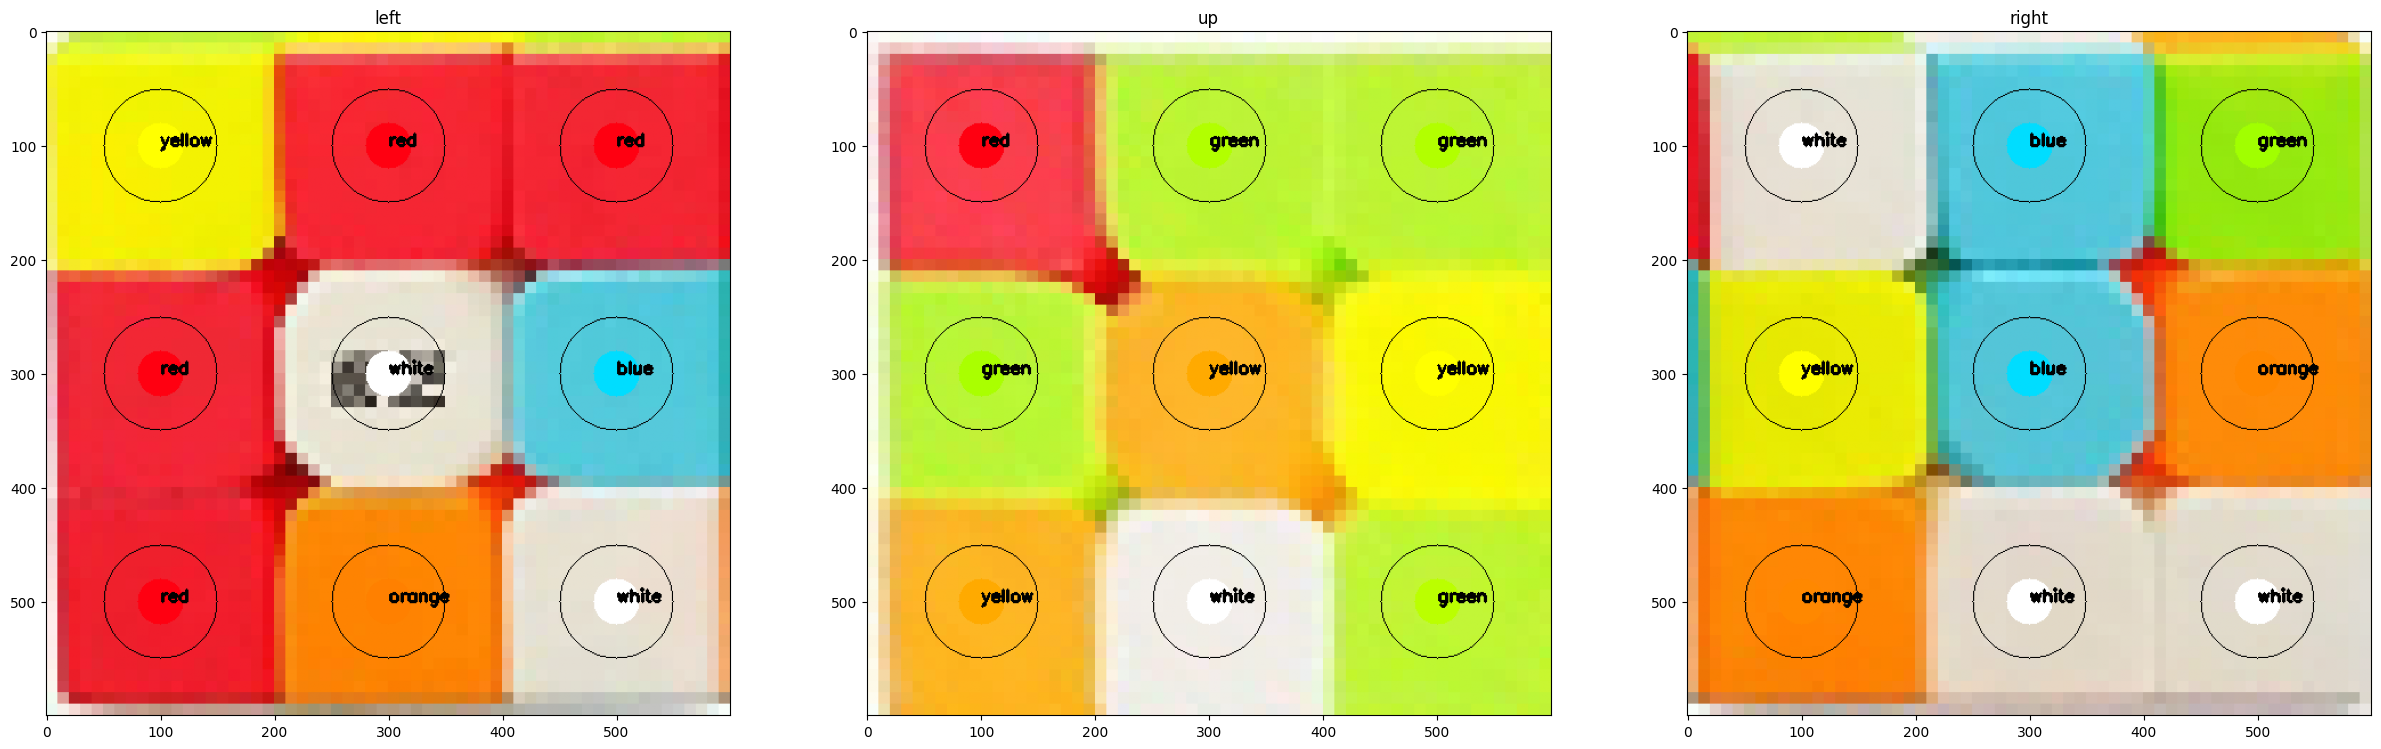

In [ ]:
tmp1 = cv2.resize(result_image1, (600, 600), interpolation = cv2.INTER_AREA)
tmp2 = cv2.resize(result_image2, (600, 600), interpolation = cv2.INTER_AREA)
tmp3 = cv2.resize(result_image3, (600, 600), interpolation = cv2.INTER_AREA)

h, s, v = cv2.split(cv2.cvtColor(result_image1, cv2.COLOR_BGR2HSV))
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
hsv_image1 = cv2.merge([h, s, v])

h, s, v = cv2.split(cv2.cvtColor(result_image2, cv2.COLOR_BGR2HSV))
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
hsv_image2 = cv2.merge([h, s, v])

h, s, v = cv2.split(cv2.cvtColor(result_image3, cv2.COLOR_BGR2HSV))
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
hsv_image3 = cv2.merge([h, s, v])

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):

        hue_average_color = most_common_hue(hsv_image1, (i,j), 5)
        color_name, bgr_color = hue_to_color_name_and_bgr(hue_average_color)
        color = (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2])) 
        
        cv2.circle(tmp1, (j*10, i*10), 50, (0, 0, 0), 1)
        cv2.circle(tmp1, (i*10, j*10), 20, color, thickness=cv2.FILLED)
        cv2.putText(tmp1, color_name, (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        hue_average_color = most_common_hue(hsv_image2, (i,j), 5)
        color_name, bgr_color = hue_to_color_name_and_bgr(hue_average_color)
        color = (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2]))

        cv2.circle(tmp2, (j*10, i*10), 50, (0, 0, 0), 1)
        cv2.circle(tmp2, (i*10, j*10), 20, color, thickness=cv2.FILLED)
        cv2.putText(tmp2, color_name, (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        hue_average_color = most_common_hue(hsv_image3, (i,j), 5)
        color_name, bgr_color = hue_to_color_name_and_bgr(hue_average_color)
        color = (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2]))
        
        cv2.circle(tmp3, (j*10, i*10), 50, (0, 0, 0), 1)
        cv2.circle(tmp3, (i*10, j*10), 20, color, thickness=cv2.FILLED)
        cv2.putText(tmp3, color_name, (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

imshow_all(cv2.cvtColor(tmp3, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp1, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp2, cv2.COLOR_BGR2RGB),titles=["left","up","right"])